In [1]:
import sklearn.model_selection
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
from math import floor
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
excel = pd.read_csv(f'./HRDataset_v14.csv')
excel = pd.DataFrame(excel)
excel.head(5)

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [4]:
excel.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'Salary', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30',
       'Absences'],
      dtype='object')

In [5]:
excel.shape

(311, 36)

In [6]:
excel['Age'] = excel.apply(
    lambda row: 2021 - (
        datetime.strptime(row['DOB'], '%m/%d/%y').replace(
            year=datetime.strptime(row['DOB'], '%m/%d/%y').year - 100
        ) if datetime.strptime(row['DOB'], '%m/%d/%y').year > 2010 else datetime.strptime(row['DOB'], '%m/%d/%y')
    ).year,
    axis=1
)

In [7]:
excel = excel.drop([
    'Employee_Name',
    'EmpID',
    'Position',
    'Sex',
    'MaritalDesc',
    'TermReason',
    'EmploymentStatus',
    'Department',
    'ManagerName',
    'PerformanceScore',
    'FromDiversityJobFairID',
    'State',
    'Zip',
    'CitizenDesc',
    'HispanicLatino',
    'RaceDesc',
    'RecruitmentSource',
    'EngagementSurvey',
    'SpecialProjectsCount',
    'DaysLateLast30',
    'ManagerID',
    'LastPerformanceReview_Date',
    'DateofHire',
    'DateofTermination',
    'EmpStatusID',
    'DOB'
], axis=1)
excel.head(5)

,MarriedID,MaritalStatusID,GenderID,DeptID,PerfScoreID,Salary,Termd,PositionID,EmpSatisfaction,Absences,Age
0,0,0,1,5,4,62506,0,19,5,1,38
1,1,1,1,3,3,104437,1,27,3,17,46
2,1,1,0,5,3,64955,1,20,3,3,33
3,1,1,0,5,3,64991,0,19,5,15,33
4,0,2,0,5,3,50825,1,19,4,2,32


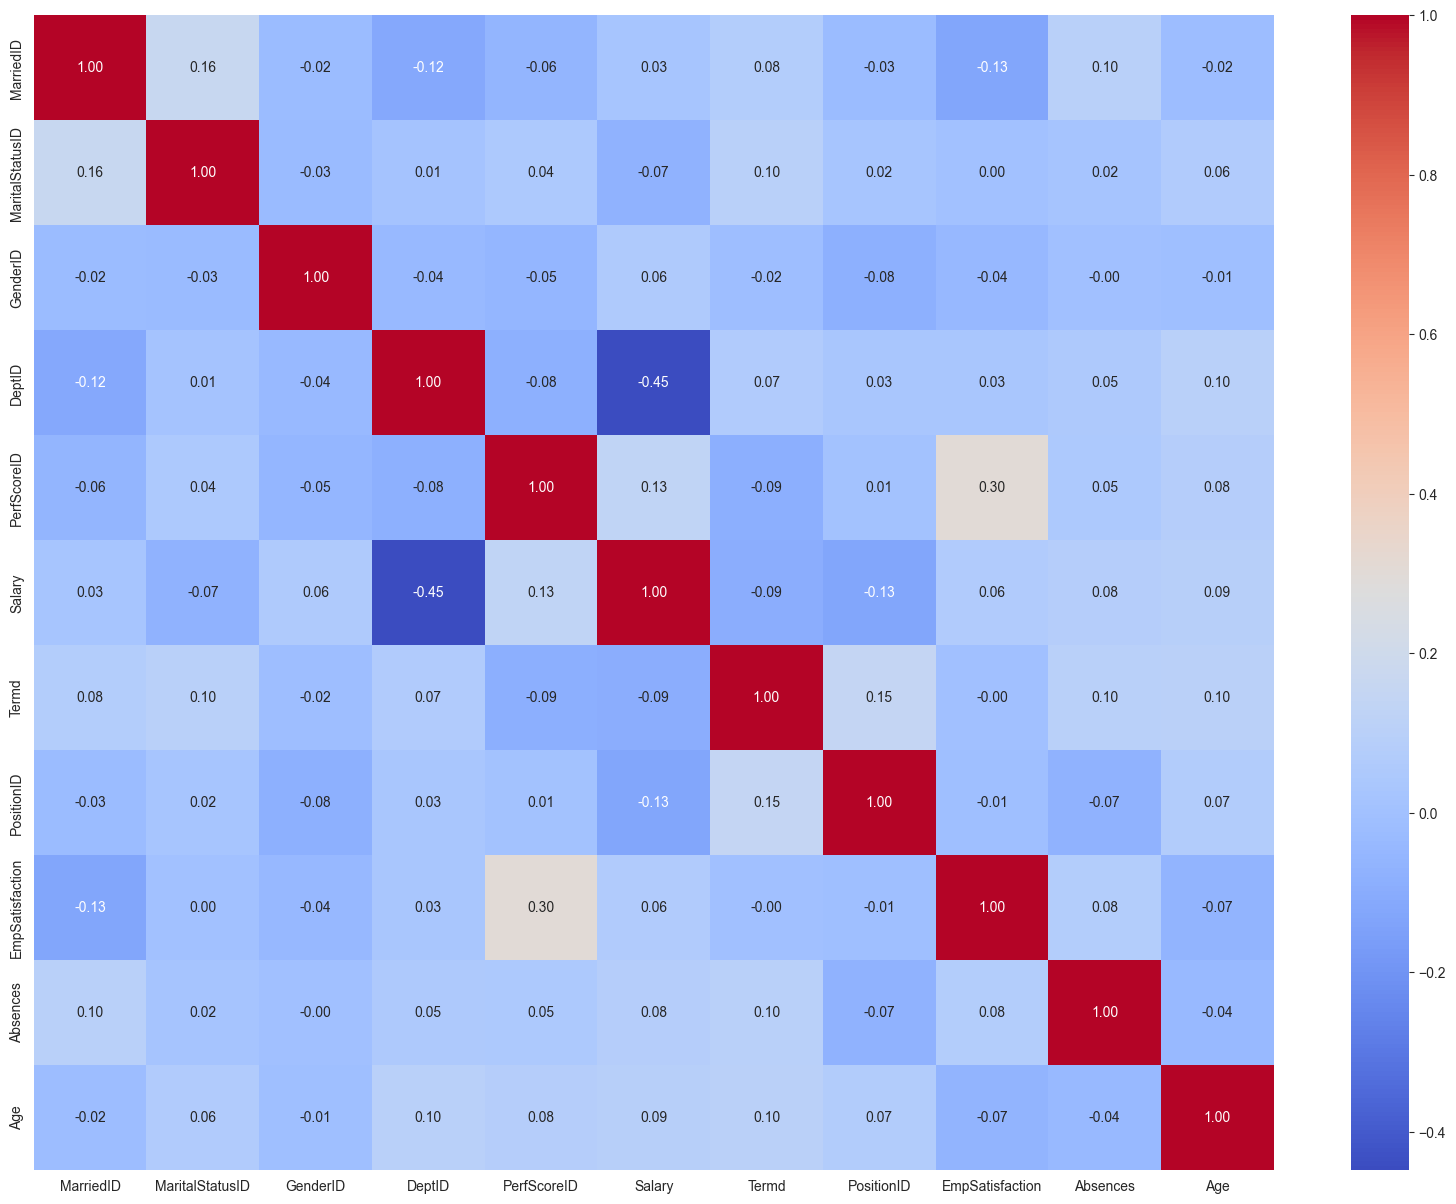

In [8]:
plt.figure(figsize=(20, 15))
data_correlation = excel.corr()
sns.heatmap(data_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

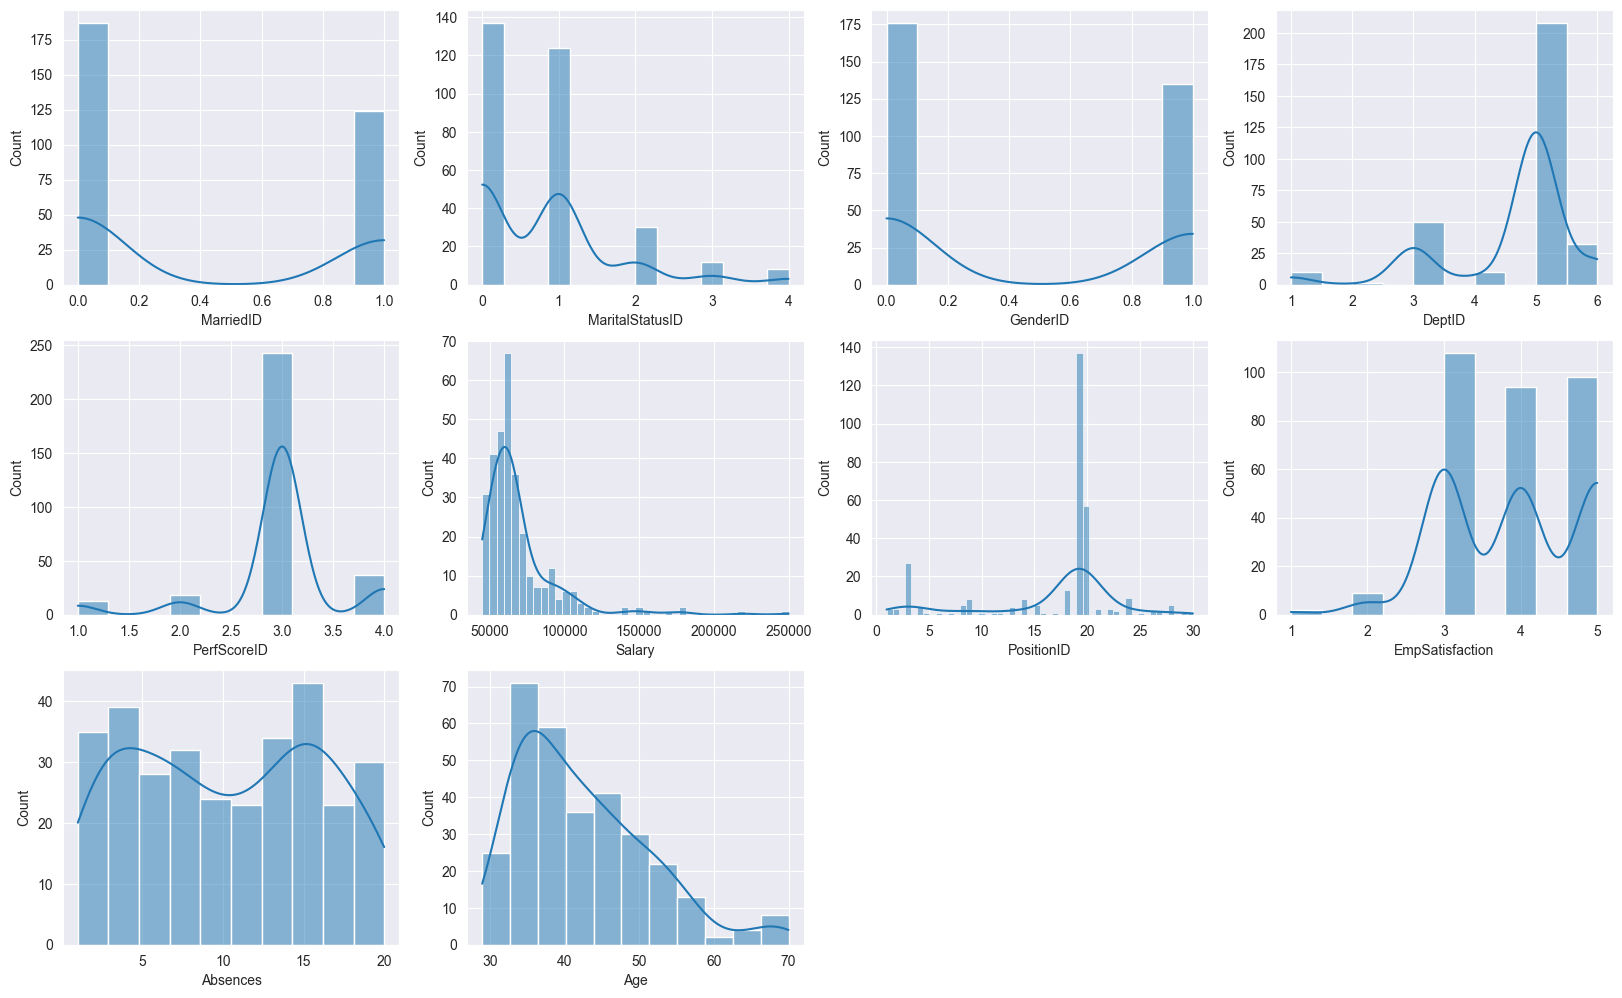

In [9]:
features = [feature for feature in excel.columns if feature != 'Termd']

rows = 6
cols = 4
plt.figure(figsize=(20, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data=excel, x=feature, kde=True, palette='muted', multiple='stack')
    # plt.title(feature)

In [10]:
# # Visualisasi dengan box plot
# plt.figure(figsize=(10, 6))
# sns.boxplot(excel.drop('Salary', axis=1))
# plt.title('Box plot After Adjustment of outliers')
# plt.xticks(rotation=45)
# plt.show()

In [11]:
random_state = 7

In [12]:
# Tidak perlu dimasukkan karena ini adalah penyesuaian agar sesuai dengan data real. Untuk saat ini, data yang digunakan adalah data dummy.
percentages = [0.05, 0.10, 0.15, 0.20]
datasets = {}
percentage = percentages[1] # Change this to select different percentages

# Separate positive and negative cases
positive = excel[excel['Termd'] == 1]
negative = excel[excel['Termd'] == 0]

# Set the number of non-turnover samples you want
n_non_turnover = 200

# Sample non-turnover employees
sampled_non_turnover = negative.sample(n=n_non_turnover, random_state=random_state)

# for pct in percentages:
n_pos = int(percentage * len(sampled_non_turnover))
sampled_pos = positive.sample(n=n_pos, random_state=42)
combined = pd.concat([sampled_non_turnover, sampled_pos]).sample(frac=1, random_state=random_state).reset_index(drop=True)

In [13]:
combined.groupby('Termd').size()

Termd
0    200
1     20
dtype: int64

In [14]:
X = combined.drop('Termd', axis=1)
y = combined['Termd']

In [15]:
dtrain = xgboost.DMatrix(X, label=y)

In [16]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [17]:
parameters = {
    'objective':'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 3,
    'seed': random_state,
    'n_estimators': 100,
}
param_grid = {
    'max_depth': [3, 4, 5],             # Batasi kedalaman pohon, jangan terlalu dalam
    'learning_rate': [0.1, 0.05, 0.01], # Laju belajar yang lebih kecil
    'n_estimators': [100, 200, 300],    # Jumlah pohon
    'gamma': [0, 0.1, 0.2],             # Parameter regularisasi untuk mengontrol kompleksitas
    'subsample': [0.8, 0.9],            # Persentase sampel data untuk setiap pohon
    'colsample_bytree': [0.8, 0.9]      # Persentase fitur (kolom) untuk setiap pohon
}

# xgb_classifier = xgboost(
#     **parameters
# )

In [18]:
xgboost1 = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

In [19]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=xgboost1,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=kfold,
    verbose=2)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [21]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 0.9], 'gamma': [0, 0.1, ...], 'learning_rate': [0.1, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [22]:
# 6. Lihat parameter terbaik yang ditemukan
print("Best parameters found: ", grid_search.best_params_)

# 7. Gunakan model terbaik untuk prediksi
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}


In [26]:
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
accuracy_train_scores, precision_train_scores, recall_train_scores, f1_train_scores = [], [], [], []

# Cross-validation manual
for train_idx, val_idx in kfold.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    dtrain_fold = xgboost.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgboost.DMatrix(X_val_fold, label=y_val_fold)

    # Train model di fold ini
    # xgb_classifier.fit(X_train_fold, y_train_fold)
    xgb_model = xgboost.train(
        params=param,
        dtrain=dtrain_fold,
        num_boost_round=parameters['n_estimators']
    )

    # Prediksi (returns probabilities for binary classification)
    y_pred_proba = xgb_model.predict(dval_fold)
    y_pred_train_proba = xgb_model.predict(dtrain_fold)
    # Convert probabilities to binary predictions
    y_pred_fold = (y_pred_proba > 0.5).astype(int)
    y_pred_train_fold = (y_pred_train_proba > 0.5).astype(int)

    # Simpan metrik
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    precision_scores.append(precision_score(y_val_fold, y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold, average='weighted'))
    accuracy_train_scores.append(accuracy_score(y_train_fold, y_pred_train_fold))
    precision_train_scores.append(precision_score(y_train_fold, y_pred_train_fold, average='weighted'))
    recall_train_scores.append(recall_score(y_train_fold, y_pred_train_fold, average='weighted'))
    f1_train_scores.append(f1_score(y_train_fold, y_pred_train_fold, average='weighted'))

In [27]:
# Ambil rata-rata dari tiap metrik
accuracy = np.mean(accuracy_scores)
precision = np.mean(precision_scores)
recall = np.mean(recall_scores)
f1 = np.mean(f1_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Precision: %.2f%%" % (precision * 100.0))
print(f"Recall: %.2f%%" % (recall * 100.0))
print(f"F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 85.00%
Precision: 82.09%
Recall: 85.00%
F1 Score: 83.44%


In [28]:
# Ambil rata-rata dari tiap metrik
accuracy_train = np.mean(accuracy_train_scores)
precision_train = np.mean(precision_train_scores)
recall_train = np.mean(recall_train_scores)
f1_train = np.mean(f1_train_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy_train * 100.0))
print(f"Precision: %.2f%%" % (precision_train * 100.0))
print(f"Recall: %.2f%%" % (recall_train * 100.0))
print(f"F1 Score: %.2f%%" % (f1_train * 100.0))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


In [106]:
xgb_model.save_model('xgboost_model.json')

In [107]:
combined.to_csv('combined_dataset.csv', index=False)